# 3. PKA
We will limit ourself to zero-Kelvin. That means no more equilibration is performed before PKA simulation. In this chapter, we will see how PKA simulation is done.

## 3.1 Copy files
- Copy "CH.airebo" from "2. Minimize" folder.
- Copy "data.new.lmp" from "2. Minimize" folder and rename it "data.lmp".

In [1]:
from pathlib import Path
from shutil import copy
cwd = Path.cwd()
source = cwd.parent/'2. Minimize'

copy(source/'CH.airebo', cwd)
copy(source/'data.new.lmp', cwd/'data.lmp')

WindowsPath('c:/Users/fitbe/OneDrive/Desktop/PKA Tutorial/LAMMPS/3. PKA/data.lmp')

## 3.2 PKA Preparation
We need to pick a random atom near the center of the box as our PKA. The easiest way is to do it externally and then tell LAMMPS the atom id.

### 3.2.1. Load data file using OVITO Python
Please read https://www.ovito.org/manual_testing/python/introduction/file_io.html#data-import for documentation.

In [1]:
# Import packages
from ovito.io import import_file

In [2]:
# Load the data file
pipeline = import_file(location='data.lmp', input_format='lammps/data', atom_style='atomic')
data = pipeline.compute()   # By default, the first frame is computed

In [3]:
# Read the atom ids, types and positions
id = data.particles['Particle Identifier']
type = data.particles['Particle Type']
x = data.particles['Position'][:, 0]
y = data.particles['Position'][:, 1]
z = data.particles['Position'][:, 2]

# Read the simulation box dimensions
lx, ly, lz = data.cell[0, 0], data.cell[1, 1], data.cell[2, 2]

# Print
print(f'lx = {lx}, ly = {ly}, lz = {lz}')

lx = 27.242953793064842, ly = 28.19706618373108, lz = 25.98433744793071


### 3.2.2. Pick a PKA
- We want to choose a carbon atom inside a cubic box centered at the center of the simulation box. The cubic box size is 6 Å.
- We assign the kinetic energy (eV) and generate two random values between 0 and 1 for PKA direction.

In [4]:
# Import packages
import random

In [5]:
# Find the center of the simulation box
cx, cy, cz = lx/2, ly/2, lz/2

# Find the atom ids for the carbon atoms (type 1) inside the cubic box
d = 6
r = d/2
id1 = id[(x > cx - r) & (x < cx + r) & (y > cy - r) & (y < cy + r) & (z > cz - r) & (z < cz + r) & (type == 1)]

# Randomly select 1 atom from id1
random.seed(0)  # Use a different seed to generate different random numbers each time
PKA = random.sample(sorted(id1), 1)[0]  # sorted() converts list to array

# Assign the kinetic energy
E = 30 # eV

# We need 2 random numbers between 0 and 1 to assign the direction of PKA velocity
rand1 = round(random.random(), 2)
rand2 = round(random.random(), 2)

# Print
print(f'PKA id = {PKA}, E = {E} eV')
print(f'rand1 = {rand1}, rand2 = {rand2}')

PKA id = 1610, E = 30 eV
rand1 = 0.76, rand2 = 0.42


## 3.3 Input file
The PKA input file is a bit complex. We will break it down step by step for the simulation section.
1. We define the thermo layer (3 Å for each side)
2. We define the PKA and assign the velocity based on kinetic energy E. The direction is defined with two random values between 0 and 1, i.e., a point in spherical coordinate.
3. We are interested in the per atom properties such as potential energy, kinetic energy, and displacement.
4. We are interested in the global properties such as time, temperature, kinetic energy, potential energy, total energy, and maximum kinetic enery per atom. `etotal` and `econserve` are different when thermostat is used.
5. All atoms are under NVE ensemble. Thermo layer is rescaled to 0 Kelvin to allow heat dissipation.
6. Variable timestep is used by invoking `fix dt/reset`.
7. The maximum kinetic energy per atom tells us whether the system has reached the thermal velocity. 0.05 eV is used as the threshold to end the simulation by invoking `fix halt`.

In [7]:
%%writefile in.lmp
#---------- Initization ----------#
units metal
dimension 3
boundary p p p
atom_style atomic

#---------- structure ----------#
read_data data.lmp

#---------- Force Field ----------#
pair_style airebo 3.0
pair_coeff * * CH.airebo C H

#---------- Simulation ----------#
# Group (3 Å for thermo layer)
region rthermo block 3 $(lx-3) 3 $(ly-3) 3 $(lz-3) units box side out
group thermo region rthermo

# Recoil Initiation
group PKA id ${PKA}
variable v equal 1e-2*sqrt((2*${E}/6.242e18)/(mass(PKA)/6.022e23/1000)) # unit: Å/ps
variable phi equal acos(2*${rand1}-1)
variable theta equal 2*PI*${rand2}
variable vx equal ${v}*sin(${phi})*cos(${theta})
variable vy equal ${v}*sin(${phi})*sin(${theta})
variable vz equal ${v}*cos(${phi})
velocity PKA set ${vx} ${vy} ${vz}

# Compute
compute ke all ke/atom
compute maxke all reduce max c_ke
variable maxke equal c_maxke
compute pe all pe/atom
compute disp all displace/atom

# Thermo
thermo 1
thermo_style custom step time temp ke pe etotal econserve c_maxke

# Dump
dump 1 all custom 5 dump.lmp id type element x y z vx vy vz c_ke c_pe c_disp[4]
dump_modify 1 element C H time yes

# Fix
fix 1 all nve
fix 2 thermo temp/rescale 1 0.0 0.0 0.05 1.0 # Heat dissipation
fix 3 all dt/reset 1 NULL 0.0005 0.05 emax 10 units box
fix 4 all halt 1 v_maxke < 0.05     # fix halt works only with equal-style variable

# Run
run 10000   # This can be very large if fix halt is used, else you can try for a few rounds

#---------- End ----------#
write_data data.new.lmp

Overwriting in.lmp


## 3.4. Run LAMMPS

Make sure the command line is what we want. This will be used again in Chapter 5.

In [6]:
print(f'lmp -i in.lmp -l log.lmp -v PKA {PKA} -v E {E} -v rand1 {rand1} -v rand2 {rand2}')

lmp -i in.lmp -l log.lmp -v PKA 1610 -v E 30 -v rand1 0.76 -v rand2 0.42


It takes about 3 minutes to run in my laptop.

In [8]:
!lmp -i in.lmp -l log.lmp -v PKA {PKA} -v E {E} -v rand1 {rand1} -v rand2 {rand2}

LAMMPS (2 Aug 2023 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Loaded 1 plugins from C:\Users\fitbe\AppData\Local\LAMMPS 64-bit 2Aug2023 with GUI\plugins
Reading data file ...
  orthogonal box = (0 0 0) to (27.242954 28.197066 25.984337)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  2880 atoms
  reading velocities ...
  2880 velocities
  read_data CPU = 0.012 seconds
Reading airebo potential file CH.airebo with DATE: 2011-10-25
1392 atoms in group thermo
1 atoms in group PKA
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 12.2
  ghost atom cutoff = 12.2
  binsize = 6.1, bins = 5 5 5
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair airebo, perpetual
      attributes: full, newton on, ghost
      pair build: full/bin/ghost
      stencil: full/ghost/bin/3d
      bin: 

## 3.5. Visualize the structure
Open the "dump.lmp" using OVITO software. To better see the radiation damage process, we will `Add modification`.
1. Choose `Expression selection`. Then under `Boolean expression`, type `c_disp_4_ < 0.2`. These means that only atoms less than 0.2 Å are selected.
2. Choose `Delete selected`. We want to delete the previous selected atoms as they are considered not "defective" in this case.
3. Choose `Color coding`. Then for `input property:`, choose `Velocity Magnitude`. Change `End value` to 100. Now the "defective" atoms will be colored based on their kinetic energy. Red means high and blue means low.

You can play the movie to see how cascade evolves.

Alternatively, "defective" can be defined as the Frenkal pair (interstitial and vacancy). OVITO has implemented this for us. After opening the "dump.lmp", we `Add modification`.
1. Choose `Wigner-Seitz defect analysis`. Make sure the `Output mode` is `Sites`.
2. Choose `Expression selection`. Then under `Boolean expression`, type `Occupancy !=0 ` to select sites that are not vacant.
3. Choose `Delete selected`. We want to delete the previous selected sites to show vacancies.
Be careful that the particles shown actually represent the sites they occupy. You can now watch how vacancies evolve.

If we deal with simple metals, we can also define "defective" using potential energy per atom. Atoms that have potential energy greater than the cohesive energy are defects.

## 3.6. Log file

### 3.6.1. Load log file

In [9]:
# Import packages
import lammps.formats as lf
import pandas as pd

C:\Users\fitbe\AppData\Local\Temp\ipykernel_56164\3110840304.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [10]:
# Load log file
file = lf.LogFile(filename='log.lmp')

# The file contains a list of runs and errors. We only have one run.
# Each run is a dictionary with thermo fields as keys, storing the values over time.
run = file.runs[0]

# Convert to pandas DataFrame
log = pd.DataFrame(run)

# Print
log

Step      Time       Temp     KinEng     PotEng     TotEng  Econserve  \
0        0.0  0.000000  80.606602  29.996937 -12301.663 -12271.666 -12271.666   
1        1.0  0.000228  80.414280  29.925367 -12301.590 -12271.665 -12271.665   
2        2.0  0.000456  79.863251  29.720307 -12301.383 -12271.663 -12271.663   
3        3.0  0.000685  79.009501  29.402592 -12301.064 -12271.661 -12271.661   
4        4.0  0.000915  77.917068  28.996054 -12300.656 -12271.660 -12271.660   
...      ...       ...        ...        ...        ...        ...        ...   
4401  4401.0  2.135140  14.754746   5.490831 -12292.536 -12287.045 -12271.622   
4402  4402.0  2.135640  14.397373   5.357838 -12292.401 -12287.044 -12271.621   
4403  4403.0  2.136140  14.058963   5.231902 -12292.274 -12287.042 -12271.620   
4404  4404.0  2.136640  13.789023   5.131446 -12292.173 -12287.042 -12271.619   
4405  4405.0  2.137140  13.632366   5.073148 -12292.114 -12287.041 -12271.618   

        c_maxke  
0     29.996937  
1     29.925243  
2     29.718530  
3     29.394310  
4     28.971899  
...         ...  
4401   0.119038  
4402   0.087578  
4403   0.058085  
4404   0.055278  
4405   0.049447  

[4406 rows x 8 columns]

### 3.6.2. Total energy
We want to check numerical stability. An easy way is to see if the total energy is conserved, shown below. In this case, `econserve` should be used.

<Axes: xlabel='Time (ps)', ylabel='Total Energy Change (eV)'>

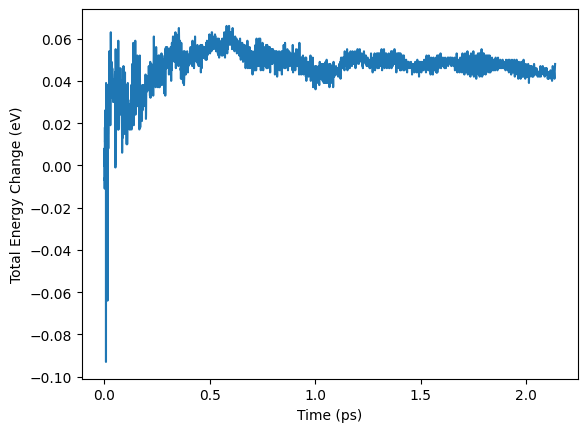

In [11]:
# Plot the total energy change
log['del_e'] = log['Econserve'] - log['Econserve'][0]
log.plot(x='Time', y='del_e', xlabel='Time (ps)', ylabel='Total Energy Change (eV)', legend=False)

### 3.6.3. Maximum kinetic energy per atom

<Axes: xlabel='Time (ps)', ylabel='Max Kinetic Energy (eV)'>

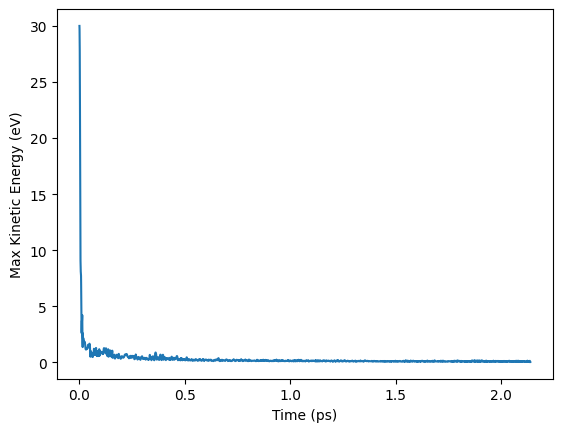

In [12]:
log.plot(x='Time', y='c_maxke', xlabel='Time (ps)', ylabel='Max Kinetic Energy (eV)', legend=False)

### 3.6.3. Potential energy
We can see that potential energy increases at the early stage and then drops to a value higher than the initial state. This is expected becauses likely PKA has created defects in the system.

<Axes: xlabel='Time (ps)', ylabel='Potential Energy Change (eV)'>

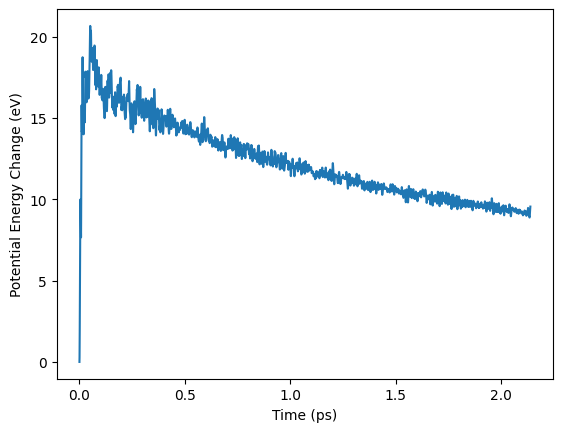

In [13]:
# Plot the potential energy change
log['del_pe'] = log['PotEng'] - log['PotEng'][0]
log.plot(x='Time', y='del_pe', xlabel='Time (ps)', ylabel='Potential Energy Change (eV)', legend=False)

### 3.6.4. Temperature
We have seen that the temperature is very high initially and then drops to a value near 0 kelvin.

<Axes: xlabel='Time (ps)', ylabel='Temperature (K)'>

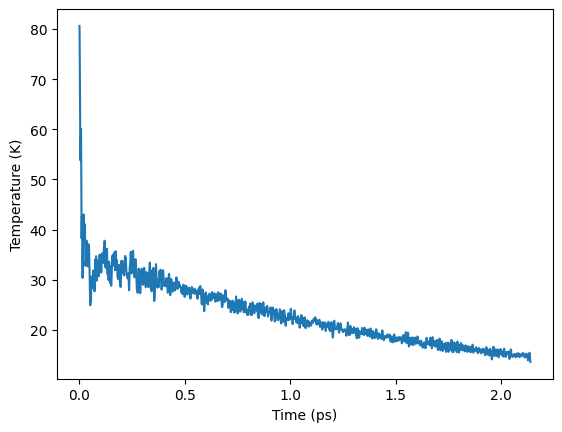

In [14]:
# Plot the density
log.plot(x='Time', y='Temp', xlabel='Time (ps)', ylabel='Temperature (K)', legend=False)